<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/XAI_Visualizing_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 4: Visualizing Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

In this notebook, you will learn how to visualize a convolutional neural network (CNN) pretrained to perform image classification on ImageNet dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Visualizing image-specific class saliency maps](#1)
2. [Visualizing class representative images](#2)
3. [Generating adversarial examples](#3)

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016. [[pdf]](https://arxiv.org/pdf/1602.07360.pdf)
- [4] Simonyan et al., "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014. [[pdf]](https://arxiv.org/pdf/1312.6034.pdf)
- [5] Szegedy et al., "Intriguing properties of neural networks", ICLR 2014. [[pdf]](https://arxiv.org/pdf/1312.6199.pdf)
- [6] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)
- [7] Yosinski et al., "Understanding Neural Networks Through Deep Visualization", ICML Workshop 2015. [[pdf]](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)

## Load datasets and a pretrained model
The ImageNet validation dataset (which was not used in the training) and a pretrained CNN model will be downloaded automatically if it is not located in the *Utils* directory. You can use any model here, but for the purposes of this assignment you will use **SqueezeNet** [3], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

!gdown --id 1zwOgR0yJ3Mrjpq_eT5nHt5CiYYDEkdBN

Downloading...
From: https://drive.google.com/uc?id=1zwOgR0yJ3Mrjpq_eT5nHt5CiYYDEkdBN
To: /content/imagenet_val_25.npz
3.94MB [00:00, 59.0MB/s]


In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def _deprocess_image(img, MEAN=IMAGENET_MEAN, STD=IMAGENET_STD):
    """ Undo preprocessing on an image and convert back to uint8. """
    return np.clip(255 * (img * STD + MEAN), 0.0, 255.0).astype(np.uint8)

def _preprocess_image(img, MEAN=IMAGENET_MEAN, STD=IMAGENET_STD):
    """ Preprocess an image: subtracts the pixel mean and divides by the standard deviation.  """
    return (img.astype(np.float32)/255.0 - MEAN) / STD

def plot_images(X, Y, C, idx=0, Each_Category=False, SaliencyMaps=None, ClassRepresentatve=None, Adversarial=None, Target_y=None):
    ''' Plot images '''
    if Each_Category:
        Category = set(Y)
        for i in range(10):
            while(1):
                if Y[idx] in Category:
                    Category.remove(Y[idx])
                    break
                else:
                    idx += 1
            
            plt.subplot(2, 5, Y[idx]+1)
            plt.imshow(_deprocess_image(X[idx], CIFAR10_MEAN, CIFAR10_STD))
            plt.title(C[Y[idx]])
            plt.axis('off')
            
    elif SaliencyMaps is not None:    
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
            plt.subplot(2, 5, i+6)
            plt.imshow(SaliencyMaps[idx+i], cmap=plt.cm.hot)
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
    elif ClassRepresentatve is not None:    
        Iter = int(X.shape[0] / 4)
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(X[Iter*(i+1)])
            plt.title('%s\nIteration %d' % (C[Y], Iter*(i+1)))
            plt.axis('off')
            plt.gcf().set_size_inches(8, 8)
            
    elif Adversarial is not None:
        plt.subplot(1, 4, 1)
        plt.imshow(X[0])
        plt.title(C[Y[0]])
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(Adversarial[0])
        plt.title(C[Target_y])
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow((X-Adversarial)[0])
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (10x)')
        plt.imshow(10 * (X-Adversarial)[0])
        plt.axis('off')          
        
    else:
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min image value -1.000000
Max image value 1.000000
Data shape (5, 224, 224, 3)
Labels shape (5,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


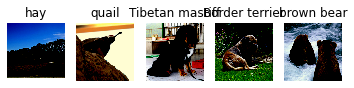

In [ ]:
def load_ImageNet_val(num=5):
    f = np.load('/content/imagenet_val_25.npz', allow_pickle=True)
    X = f['X']
    Y= f['y']
    Class_names = f['label_map'].item()

    if num is not None:
      X = X[:num]
      Y = Y[:num]

    Class_names = {i:c.split(',')[0] for i, c in Class_names.items()}

    return X, Y, Class_names

X, Y, Class_names = load_ImageNet_val(num=5)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
X=preprocess_input(X.astype(np.float32))
print('Min image value %f'%np.min(X))
print('Max image value %f'%np.max(X))
print('Data shape ' + str(X.shape))
print('Labels shape ' + str(Y.shape))
plot_images(X, Y, Class_names)

In [ ]:
# Clear old variables
tf.keras.backend.clear_session()

# Create the base model from the pre-trained model MobileNet V2
model = tf.keras.applications.MobileNetV2(weights='imagenet', classifier_activation=None)
model.trainable = False
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## <a name="1"></a> 1. Visualizing image-specific class saliency maps

In this section, you will visualize image-specific class saliency maps from the pretrained model (Section 3.1 of [4]).

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

**Complete** the implemeation of the `compute_saliency_maps` function and visualize some class saliency maps on our example images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


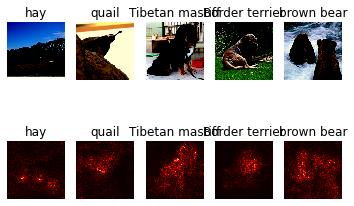

In [ ]:
def compute_saliency_maps(model, X, Y):
    """ Compute a class saliency map using the model for images X and labels Y """
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    saliency=[]
    for i in range(len(Y)):
        image = tf.cast(X[i:i+1], tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(image)
            preds = model(image)
            top_class = preds[:,Y[i]]
        grads = tape.gradient(top_class, image)
        grads = tf.abs(grads)
        saliency.append(tf.reduce_max(grads, axis=3)[0])
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

SaliencyMaps = compute_saliency_maps(model, X, Y)
plot_images(X, Y, Class_names, SaliencyMaps=SaliencyMaps)


## <a name="2"></a> 2. Visualizing class representative images

In this section, you will visualize class representative images from the pretrained model (Section 2 of [4] and [7]).

By starting with a random noise image and performing gradient ascent on a target class, you can generate an **class representative image** in terms of the CNN class scoring model. More formally, let $S_c(I)$ be the unnormalized score of the class $c$, compuuted by the CNN model for an image $I$. Generate an image $I^*$ with regularizer $R(I)$ that achieves a high score for the class $y$ by solving the problem:

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

In this assignment, you will use  **L2 regularization** suggested by [4] and periodic **gaussian blur** regularization suggested by [7].

**Complete** the implemeation of the `compute_class_representative_image` function and visualize some classes.

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
def random_noise_image(num_iterations=100):
    X = 255 * np.random.rand(num_iterations, 224, 224, 3)
    return X

def jitter_image(X, ox, oy):
    Xi = np.roll(np.roll(X, ox, 1), oy, 2)
    return Xi

def unjitter_image(X, ox, oy):
    Xi = np.roll(np.roll(X, -ox, 1), -oy, 2)
    Xi = np.clip(Xi, -1.0, 1.0)
    return Xi

def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


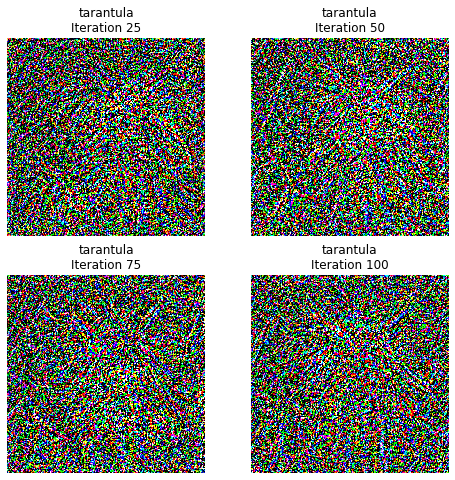

In [ ]:
def compute_class_representative_image(model, target_y, preprocess_input):
    """ Compute a class representative image using the model for target class y """
    #Training parameters
    l2_reg = 1e-5
    learning_rate = 200
    num_iterations = 100
    blur_every = 10
    show_every = 25
    max_jitter = 16

    # Generate a random noise image: 
    # Numpy array of shape (Num_iterations, H, W, 3) for saving intermediate images
    X = random_noise_image(num_iterations+1)
    X = preprocess_input(X.astype(np.float32))
    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = jitter_image(X[t:t+1], ox, oy)
        #Xi=X[t:t+1]
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        image = tf.cast(Xi, tf.float32)
        with tf.GradientTape() as tape:
          tape.watch(image)
          preds = model(image)
          top_class = preds[:, target_y]
          reg = tf.nn.l2_loss(image+1)
          obj = top_class - reg*l2_reg
        grads = tape.gradient(obj, image)
        del tape
        Xi = Xi + grads * learning_rate
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################    

        # Unjitter and clip the image
        Xi = unjitter_image(Xi, ox, oy)
        #Xi = np.clip(Xi, -1.0, 1.0)
        
        # Blur preriodically
        if t % blur_every == 0:
            Xi = blur_image(Xi, sigma=0.00001)

        # Save intermediate images
        X[t+1] = Xi
           
    return X
  
target_y = 76 # Tarantula
#target_y = 78 # Tick
#target_y = 187 # Yorkshire Terrier
#target_y = 683 # Oboe
#target_y = 366 # Gorilla
#target_y = 604 # Hourglass
#target_y = np.random.randint(1000)
CR = compute_class_representative_image(model, target_y, preprocess_input)
plot_images(CR, target_y, Class_names, ClassRepresentatve=True)

## <a name="3"></a> 3. Generating adversarial examples ( 10 points )

In this section, you will generate adversarial examples from the pretrained model ( [5] ).

By starting with an image (cf. random noise) and performing gradient ascent on a target class, you can generate an **adversarial exapmle** in terms of the CNN class scoring model. Adversarial examples cause a state-of-the-art neural network to mis-classify any input image to whatever class you choose, even though the added noises are imperceptible to humans.

In this assignment, you will use **L2 regularization** to normalize the gradients when computing an image update.

**Complete** the implemeation of the `generate_adversarial_image` function and generate some adversarial examples.

Iteration:0	Target:6	Pred:958
Iteration:1	Target:6	Pred:958
Iteration:2	Target:6	Pred:958
Iteration:3	Target:6	Pred:958
Iteration:4	Target:6	Pred:958
Iteration:5	Target:6	Pred:958
Iteration:6	Target:6	Pred:958
Iteration:7	Target:6	Pred:958
Iteration:8	Target:6	Pred:958
Iteration:9	Target:6	Pred:958
Iteration:10	Target:6	Pred:958
Iteration:11	Target:6	Pred:958
Iteration:12	Target:6	Pred:958
Iteration:13	Target:6	Pred:958
Iteration:14	Target:6	Pred:958
Iteration:15	Target:6	Pred:958
Iteration:16	Target:6	Pred:958
Iteration:17	Target:6	Pred:958
Iteration:18	Target:6	Pred:958
Iteration:19	Target:6	Pred:958
Iteration:20	Target:6	Pred:958
Iteration:21	Target:6	Pred:958
Iteration:22	Target:6	Pred:958
Iteration:23	Target:6	Pred:958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration:24	Target:6	Pred:6


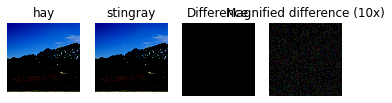

In [ ]:
def generate_adversarial_image(X, target_y, model):
    """ Generate a fooling image that is close to X, but that the model classifies as target_y. """
    #Training parameters
    learning_rate =  0.005
    num_iterations = 100
    
    X_adversarial = X.copy()
  
    for i in range(num_iterations):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        image = tf.cast(X_adversarial, tf.float32)
        with tf.GradientTape() as tape:
          tape.watch(image)
          preds = model(image)
          obj = preds[:, target_y]
        grads = tape.gradient(obj, image)
        delta = np.sign(grads)
        X_adversarial = X_adversarial + learning_rate * delta
        X_adversarial = np.clip(X_adversarial, X-0.01, X+0.01)
        X_adversarial = np.clip(X_adversarial, -1.0, 1.0)
        pred_y = np.argmax(model(X_adversarial))
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################      
        print("Iteration:%d\tTarget:%d\tPred:%d" % (i, target_y, pred_y))
        
        if target_y == pred_y:
            break
            
    assert target_y == pred_y, 'The network is not fooled!'
    return X_adversarial

image_idx = 0
target_y = 6
X_adversarial = generate_adversarial_image(X[image_idx:image_idx+1], target_y, model)
plot_images(X[image_idx:image_idx+1], Y[image_idx:image_idx+1], Class_names, Adversarial=X_adversarial, Target_y=target_y)